# Noise propagation in HQNSL quantum loss
In this notebook we will generalize the work of `NoisyState.ipynb` to include a noisy circuit. While the error on the prepared state is fixed, the error of the circuit is dynamical, changing between every iteration of each epoch.

In [1]:
from __loss_funcs import KL
from __helpers import prepare_basis, qubit_expansion
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __class_HQNet import HQNet
from __class_PQC import PQC
import numpy as np
import torch as t
from qiskit.quantum_info import Statevector
%matplotlib inline
from qiskit.providers.aer import AerSimulator
from qiskit import transpile, QuantumRegister
from qiskit.providers.aer.noise import pauli_error, depolarizing_error
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [2]:
NUM_QUBITS = 3
qreg = QuantumRegister(NUM_QUBITS)
STATE_TYPE = 'GHZ'

PROB_DEPOL = 0.01

PROB_RESET = 0.01
PROB_MEAS = 0
PROB_GATE1 = 0.01

In [3]:
# Prepare noisy and noiseless GHZ State 
if STATE_TYPE == 'GHZ':
    from GHZ_generator import GHZ_state_circuit
    noiseless_state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS, qreg=qreg)
elif STATE_TYPE == 'mGHZ':
    from mGHZ_generator import mGHZ_state_circuit
    noiseless_state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = mGHZ_state_circuit(L=NUM_QUBITS)
elif STATE_TYPE == 'Cluster':
    from cluster_generator import cluster_state_circuit
    noiseless_state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    NUM_QUBITS = NUM_QUBITS**2
else:
    raise TypeError(f"Invalid state type '{STATE_TYPE}' specified.")
noiseless_state = noiseless_state.evolve(qc)
print(qc)

      ┌───┐          
q0_0: ┤ H ├──■────■──
      └───┘┌─┴─┐  │  
q0_1: ─────┤ X ├──┼──
           └───┘┌─┴─┐
q0_2: ──────────┤ X ├
                └───┘


## Analysis
Take some symmetries from `HQN.ipynb` and analyze the losses under some error.

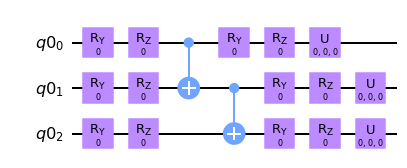

In [4]:
bases = prepare_basis(noiseless_state.num_qubits)
DEPTH = 1
MAXITER = 1E10
num_bases = len(bases)
hqn = HQNet(noiseless_state, bases, eta=1e-2, maxiter=MAXITER, disp=False,
            mode='Nelder-Mead', depth=DEPTH, 
            noise=2, state_prep_circ=qc, qreg=qreg, 
            metric_func=KL, regularize=False)

# Examine the parametrized circuit
hqn.view_circuit().draw(output='mpl')

In [5]:
# Find the symmetries of the noiseless and noisy states.
param_shape = (noiseless_state.num_qubits, DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)
NRUN = 3
param_dim = np.prod(param_shape)
proposed_syms = t.zeros((NRUN, param_dim)) # first dim is for the 3 types of noise

total_loss = 0
for j in range(NRUN):
    potential_sym, loss, regularizer_loss = hqn.find_potential_symmetry(print_log=True)
    proposed_syms[j] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape(param_shape)
    total_loss += loss
print(f"Average loss: {total_loss / NRUN}")

{'001': 29, '110': 248, '100': 36, '111': 68, '011': 239, '010': 85, '000': 162, '101': 157}
{'111 101': 1, '011 111': 1, '010 010': 2, '100 010': 1, '101 011': 4, '110 100': 1, '111 110': 59, '100 000': 3, '100 001': 10, '111 001': 1, '110 110': 1, '110 101': 26, '001 111': 3, '101 100': 6, '100 111': 3, '011 010': 12, '100 101': 34, '000 001': 5, '111 010': 11, '111 100': 14, '001 000': 8, '011 110': 16, '101 000': 46, '001 100': 4, '110 001': 1, '000 101': 80, '000 000': 2, '011 101': 4, '000 110': 5, '110 011': 55, '101 101': 1, '001 011': 3, '011 011': 4, '000 111': 18, '001 010': 17, '010 000': 2, '110 111': 42, '011 001': 2, '111 011': 4, '101 010': 44, '010 101': 18, '000 010': 1, '111 000': 27, '111 111': 1, '101 001': 2, '000 011': 32, '101 110': 33, '011 100': 8, '100 011': 43, '001 101': 3, '010 110': 1, '010 001': 3, '010 111': 10, '001 110': 111, '010 011': 119, '011 000': 56}


ValueError: operands could not be broadcast together with shapes (8,) (64,) 

#### Cross validation between noise models
Are symmetries of noisy (noiseless) states still symmetries of noiseless (noisy) states?

In [ ]:
losses = np.zeros(NRUN)
for j, sym in enumerate(proposed_syms):
    losses[j] = np.mean([PQC(noiseless_state, depth=DEPTH, basis_param=basis_here, metric_func=KL, say_hi=False)\
            .evaluate_true_metric(sym)for basis_here in bases])
print(f"{np.mean(losses)} with deviation {np.std(losses)}")


Depolarizing CV
0.00025664061342551555 with deviation 8.582059438269165e-05

General CV
0.0010585213179769386 with deviation 4.6076133441177484e-05


## Summary
If the noise is sufficiently high (e.g. high noise general bit flip) then the symmetry learning is obviously perturbed. However, for a sufficiently small noise example like the depolarizing noise, the scheme continues to learn the symmetry, at least for small qubit sizes. More tests on larger (`>5`) qubits needed.

We can distinguish between Markovian (unitary-representable) errors and non-Markovian (e.g. measurement, depolarizing) errors. The symmetries of Markovian perturbed states are easily predictable, for they essentially contain the daggers of the unitary representations of the errors. Therefore, we should expect that the scheme work well to find the noisy symmetry, but that it should have a cross validation error roughly proportional to the noise probabilities. On the other hand, non-Markovian perturbed states don't have an easily predictable symmetry, so naively we should expect very poor learning and cross validation. Amazingly, the scheme is learning poorly, but the cross validation error is just as low as if the noise were never there, implying that somehow, the scheme is filtering out the noise while learning non-Markovian symmetries! How it is doing this I have no idea, but this is a key point of discussion.